In [61]:
using Pkg
Pkg.activate(".")
using Plots
using LinearAlgebra
using ProgressMeter

  Activating project at `~/SSD/FMLB`


In [62]:
nx=259
ny=nx
iterations=350000
step=350

geometry=ones(Int, ny,nx) # wall cells
geometry[2:ny-1,2:nx-1] .= 0 # fluid cells
geometry[1,:] .= 2 # top lid

ρ0 = 1 # initial density
u0 = 0.1 # initial velocity on the top boundary

Re = 1000 # Reynolds number
ν = (nx-1)*u0/Re # Kinematic viscosity (0.005 <= ν <= 0.2)
τ = (6ν+1)/2 # relaxation time

println(ν)
println(τ)
;

0.0064
0.5192


In [63]:
C=1; E=2; S=3; W=4; N=5; NE=6; SE=7; SW=8; NW=9 # directions
f = zeros(nx*ny, 9) # distribution function of each cell
feq = zeros(Float64, nx*ny, 9) # equilibrium distribution function value
ρ = zeros(Float64, nx*ny, 1) # macroscopic density
ux = zeros(Float64, nx*ny, 1) # macroscopic velocity in x direction
uy = zeros(Float64, nx*ny, 1) # macroscopic velocity in y direction
usqr = zeros(Float64, nx*ny,1) # helper variable

f[:,C] .= ρ0*4/9 # rest initial distribution
f[:,[E, S, W, N]] .= ρ0/9 # cardinal initial distribution
f[:,[NE, SE, SW, NW]] .= ρ0/36 # diagonal initial distribution

FL = LinearIndices(geometry)[findall(==(0), geometry)] # create indices of all fluid cells
WALL = LinearIndices(geometry)[findall(==(1), geometry)] # create indices of all wall cells
DR = LinearIndices(geometry)[findall(==(2), geometry)] # create indices of all lid cells
;

In [64]:
all_u = []

@showprogress for i in 1:iterations
    # Begin collision step
    ρ[:,:] .= sum(f, dims=2)
    ux[:,:] .= (f[:,E] - f[:,W] + f[:,NE] + f[:,SE] - f[:,SW] - f[:,NW]) ./ ρ
    uy[:,:] .= (f[:,N] - f[:,S] + f[:,NE] + f[:,NW] - f[:,SE] - f[:,SW]) ./ ρ

    ux[DR] .= u0
    uy[DR] .= 0.0
    usqr[:,:] = ux.*ux + uy.*uy

    # Save velocity field
    if i%step==0
        push!(all_u, reshape(sqrt.(usqr)/u0, (ny,nx)))
    end

    feq[:,C] = (4/9)ρ.*(1 .- 1.5usqr)
    feq[:,E] = (1/9)ρ.*(1 .+ 3ux .+ 4.5ux.^2 .- 1.5usqr)
    feq[:,S] = (1/9)ρ.*(1 .- 3uy .+ 4.5uy.^2 .- 1.5usqr)
    feq[:,W] = (1/9)ρ.*(1 .- 3ux .+ 4.5ux.^2 .- 1.5usqr)
    feq[:,N] = (1/9)ρ.*(1 .+ 3uy .+ 4.5uy.^2 .- 1.5usqr)
    feq[:,NE] = (1/36)ρ.*(1 .+ 3(ux.+uy) .+ 4.5(ux.+uy).^2 .- 1.5usqr)
    feq[:,SE] = (1/36)ρ.*(1 .+ 3(ux.-uy) .+ 4.5(ux.-uy).^2 .- 1.5usqr)
    feq[:,SW] = (1/36)ρ.*(1 .+ 3(.-ux.-uy) .+ 4.5(.-ux.-uy).^2 .- 1.5usqr)
    feq[:,NW] = (1/36)ρ.*(1 .+ 3(.-ux.+uy) .+ 4.5(.-ux.+uy).^2 .- 1.5usqr)

    f[WALL, [C, E, S, W, N, NE, SE, SW, NW]] = f[WALL, [C, W, N, E, S, SW, NW, NE, SE]] # Bounce back

    f[DR,:] = feq[DR,:]

    f[FL,:] = f[FL,:].*(1-1/τ) .+ feq[FL,:] ./ τ
    # End collision step

    # Begin streaming step
    f = reshape(f, (ny, nx, 9))

    f[:,2:nx,E] = f[:,1:nx-1,E]
    f[2:ny,:,S] = f[1:ny-1,:,S]
    f[:,1:nx-1,W] = f[:,2:nx,W]
    f[1:ny-1,:,N] = f[2:ny,:,N]
    f[1:ny-1,2:nx,NE] = f[2:ny,1:nx-1,NE]
    f[2:ny,2:nx,SE] = f[1:ny-1,1:nx-1,SE]
    f[2:ny,1:nx-1,SW] = f[1:ny-1,2:nx,SW]
    f[1:ny-1,1:nx-1,NW] = f[2:ny,2:nx,NW]
    # End streaming step

    f = reshape(f, (nx*ny, 9))
end
;  

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


[ Info: Saved animation to /home/matspc/SSD/FMLB/TEMP.gif


Plots.AnimatedGif("/home/matspc/SSD/FMLB/TEMP.gif")
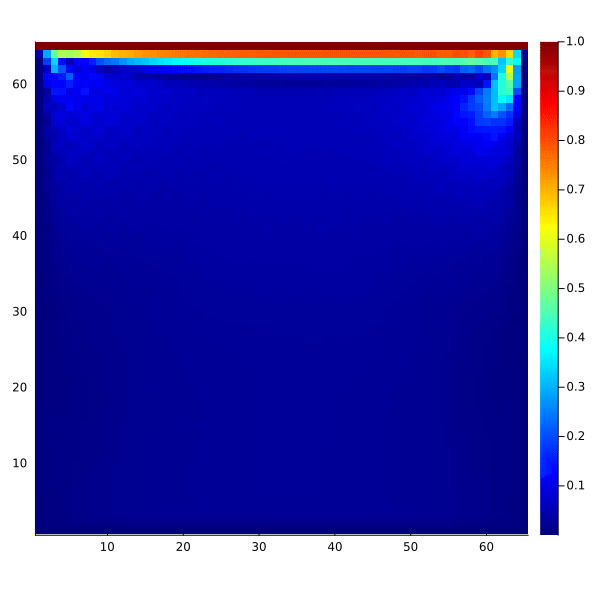

In [65]:
anim = @animate for t in 1:length(all_u)
    h = heatmap(reverse(all_u[t], dims=1), c=:jet, aspect_ratio=:equal)
    plot(h, size=(600,600))
end
gif(anim, "TEMP.gif", fps=10)